# [Tensorflow를 활용한 deep learning 이해] 
---
# <font color=blue>Image Captioning</font>

Copyright (C) Data Science & Artificial Intelligence Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Seil Lee, May 2018

In this notebook, we use tensorflow RNN libraries for image captioning of the Microsoft COCO dataset. <br>

For this exercise we will use the 2014 release of the **[Microsoft COCO dataset](http://mscoco.org/)** which has become the standard testbed for image captioning. The dataset consists of about 80,000 images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

The raw images takes up so much (nearly 20GB), we will use the preprocessed COCO datasets which are extracted features from the VGG-16 network and reduced the dimensionality of the features from 4096 to 512 by standford CS231N lecture.

Download the data : http://deepspark.snu.ac.kr/pubs/coco_data.tar.gz OR http://data.snu.ac.kr/class/coco_data.tar.gz
- caption and image index: `coco2014_captions.h5`
- idx_to_word, word_to_idx: `coco2014_vocab.json`
- extracted and reduced image features: `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`
- URLs of the images for visualization: `train2014_urls.txt` and `val2014_urls.txt`
  <br>(Since images are downloaded on-the-fly, **you must be connected to the internet to view images**)

The file `coco_utils.py` has utilities for coco datasets from load COCO data to visualization and evaluation.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.


### Some helpful tutorials and references for assignment #3:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Microsoft COCO (http://mscoco.org/dataset/#overview)
- [4] Microsoft COCO Captions (https://arxiv.org/pdf/1504.00325.pdf)
- [5] Vinyals, Oriol, et al. "Show and tell: Lessons learned from the 2015 mscoco image captioning challenge." IEEE transactions on pattern analysis and machine intelligence 39.4 (2017): 652-663.



## Image Captioning

- input : extracted image features from the VGG-16 network<br>
- output: predicted captions<br>
- evaluation: average BLEU scores for validation and independent test dataset
- data: `./coco/coco_captioning`
- model: save your captiong model in model_path (`./models`)

### Example of image captioning 

<img src="./files/showandtell.png" width=70%>
[Source: "Show and Tell: Lessons learned from the 2015 MSCOCO Image Captioning Challenge."]

### Preprocessing of language model
<img src="./files/we.png" width=70%>

## Load libraries
The preprocessed COCO datasets and libraries are loaded.<br>

In [1]:
import tensorflow as tf
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.python.platform
from coco_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_path='./models'
data_path ='./coco_captioning'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.

# image feature
# data = load_coco_data(base_dir=data_path) #for 512 features
# data = load_coco_data(base_dir=data_path, pca_features=False)  #for 4096 features

data = load_coco_data(base_dir=data_path)
if len(data)==10 : 
    print('COCO data load complete')

for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
features <class 'numpy.ndarray'> (82783, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
urls <class 'numpy.ndarray'> (82783,) <U63
val_captions <class 'numpy.ndarray'> (10000, 17) int32
val_image_idxs <class 'numpy.ndarray'> (10000,) int32


## Sample images and captions

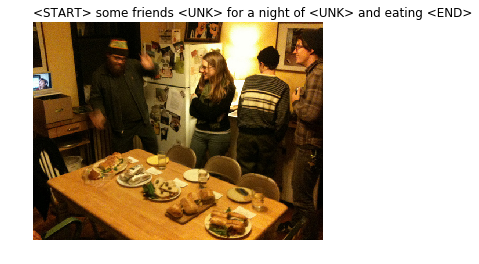

In [2]:
captions, features, urls = sample_coco_minibatch(data, batch_size=1)
show_samples(captions, urls, data)

## Training

For simple test, you can load subsample of total train data.<br>
You will be able to verify your captioning model more quickly with the small train data.<br>

In [13]:
from captioning import *

#-------------------------------------------
# CAUTION: Do not change maxlen, n_words
# you should use 512 extracted image features
#-------------------------------------------

# Try to subsamples of train_data for simple test
train_data = load_coco_data(max_train=500)
#train_data = load_coco_data()

# Try to total train_data for final test
#train_data = data

def train(img_features, captions):
    print(maxlen, n_words, captions.shape)
    cap_train(img_features, captions, maxlen, n_words, word_to_idx, model_path) 

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx]
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]
input_dimension = train_data['features'].shape[1]

print('n_word:', n_words)
print('maxlen:', maxlen)
print('(img_features.shape, caption.shape):', img_features.shape, captions.shape)

vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]
print('(vimg_features.shape, vcaption.shape):', vimg_features.shape, vcaptions.shape)

train(img_features, captions) 

n_word: 1004
maxlen: 17
(img_features.shape, caption.shape): (500, 512) (500, 17)
(vimg_features.shape, vcaption.shape): (10000, 512) (10000, 17)
17 1004 (500, 17)
Current Cost:  6.881985 	 Epoch 0/1000 	 Iter 256/500
Current Cost:  0.5163021 	 Epoch 100/1000 	 Iter 256/500
Current Cost:  0.07343476 	 Epoch 200/1000 	 Iter 256/500
Current Cost:  0.063483655 	 Epoch 300/1000 	 Iter 256/500
Current Cost:  0.017654186 	 Epoch 400/1000 	 Iter 256/500
Current Cost:  0.010338753 	 Epoch 500/1000 	 Iter 256/500
Current Cost:  0.006912445 	 Epoch 600/1000 	 Iter 256/500
Current Cost:  0.0049301414 	 Epoch 700/1000 	 Iter 256/500
Current Cost:  0.0036679334 	 Epoch 800/1000 	 Iter 256/500
Current Cost:  0.0028063778 	 Epoch 900/1000 	 Iter 256/500


## Evaluation

You can test your model in train, validation samples with sample images.<br>

In [14]:
train_data = load_coco_data()

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx]
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']
vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]

def image_captioning(features) : 
    return img_captioning(word_to_idx, maxlen, n_words, model_path, features)

INFO:tensorflow:Restoring parameters from ./models\model


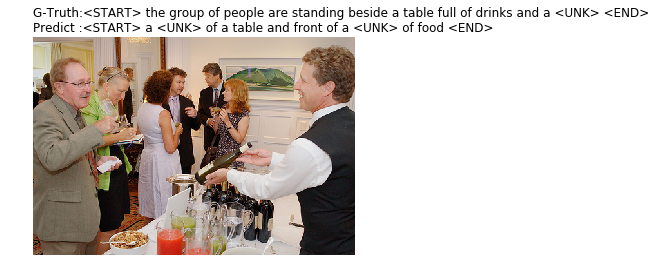

INFO:tensorflow:Restoring parameters from ./models\model


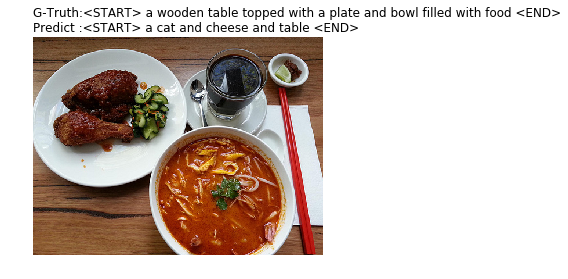

In [16]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(train_data, split=split, batch_size=1)

    gt_captions, features, urls = minibatch
    pr_captions = img_captioning(word_to_idx, maxlen, n_words, model_path, features)

    show_predict_samples(gt_captions, pr_captions, urls, data)